# Breast Cancer Prediction in Histology Images
###### -Harshul Varma

***

## 1.0 Introduction

Invasive Ductal Carcinoma or IDC is the most common type of breast cancer and automated methods utilising machine learning in order to classify malignant and benign tissue can save valuable time and reduce error.

This script will identify IDC from a dataset which contains of ~5000 50x50 pixel RGB H&E stained breast cancer histoloy images.

The dataset was evaluated on various machine learning algorithms and neural network architectures and utilising data augmentation. Transfer Learning using a ResNet 50 model provided the best results in terms of accuracy metrics. Data was also balanced to have equally IDC+ and IDC- cases to yield reliable results.

## 2.0 Dataset

Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import fnmatch
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D,GlobalAveragePooling2D,Input
from tensorflow.keras.utils import to_categorical,normalize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from glob import glob
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix

Let us see how the data is stored in the folder

In [3]:
imagePatches = glob('IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1251_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1301_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1351_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1501_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1551_class0.png


It seems the labels 0 and 1 are created and are saves as 'class0.png' and 'class1.png'. We can save the respective labels in two different datasets.

In [4]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)

In [13]:
print('Total number of images: {}, where {} images are class zero- IDC(-) and {} are class one-IDC(+)'.format(len(imagePatches),len(classZero),len(classOne)))

Total number of images: 277524, where 198738 images are class zero- IDC(-) and 78786 are class one-IDC(+)


We can now make a function to create feature set (images) - x, and a label set-y

In [6]:
def proc_images(lowerIndex,upperIndex):
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

We will only use 90,000 images to create our model

In [12]:
X,Y = proc_images(0,90000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1]

Let us describe our data

In [15]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)



Total number of images: 90000
Number of IDC(-) Images: 64583
Number of IDC(+) Images: 25417
Percentage of positive images: 28.24%
Image shape (Width, Height, Channels): (50, 50, 3)


Let us look at a random image and print the corresponding image.

0


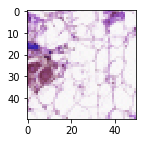

In [16]:
plt.figure(figsize=(2,2))
plt.imshow(X2[9])
print(Y2[9])

Splitting data, converting labels to one-hot vectors 

## 3.0 Model 

Splitting the data to train-test split and converting data to onehot categories

In [17]:
X=np.array(X,dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

Y_trainHot = to_categorical(Y_train)
Y_testHot = to_categorical(Y_test)


print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (81000, 50, 50, 3)
Testing Data Shape: (9000, 50, 50, 3)


We will use Transfer Learning using the ResNet50 model.

In [18]:
rn = ResNet50(weights='imagenet', include_top=False,input_shape=(50,50,3))

C:\Users\harsh\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Preprocessing and predicting using resnet50

In [19]:
train_input = preprocess_input(X_train)
new_train = rn.predict(train_input)

In [20]:
test_input = preprocess_input(X_test)
new_test = rn.predict(test_input)

Fully Conncected model on top of Resnet50 using previously predicted weights

In [21]:
model = Sequential()


model.add(GlobalAveragePooling2D(input_shape=(new_train.shape[1:])))

model.add(Dense(2))
model.add(Activation('softmax'))

adam= Adam(lr=0.00001)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(new_train,Y_trainHot,batch_size=128,epochs = 100, validation_data=(new_test,Y_testHot))

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
81000/81000 [==============================] - 3s 43us/step - loss: 0.7590 - acc: 0.6510 - val_loss: 0.6080 - val_acc: 0.7208
Epoch 2/100
81000/81000 [==============================] - 3s 35us/step - loss: 0.5665 - acc: 0.7528 - val_loss: 0.5295 - val_acc: 0.7656
Epoch 3/100
81000/81000 [==============================] - 3s 34us/step - loss: 0.5168 - acc: 0.7788 - val_loss: 0.4923 - val_acc: 0.7853
Epoch 4/100
81000/81000 [==============================] - 3s 35us/step - loss: 0.4879 - acc: 0.7923 - val_loss: 0.4674 - val_acc: 0.8002
Epoch 5/100
81000/81000 [==============================] - 3s 36us/step - loss: 0.4673 - acc: 0.8020 - val_loss: 0.4494 - val_acc: 0.8078
Epoch 6/100
81000/81000 [==============================] - 3s 36us/step - loss: 0.4520 - acc: 0.8087 - val_loss: 0.4361 - val_acc: 0.8142
Epoch 7/100
81000/81000 [==============================] - 3s 35us/step - loss: 0.4400 - acc: 0.8144 - val_loss: 0.4256 - v

Plotting Accuracy and loss

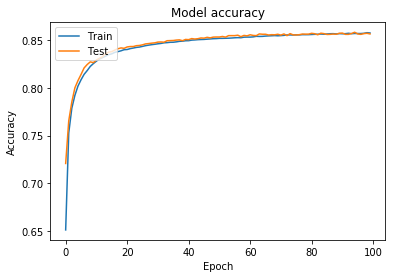

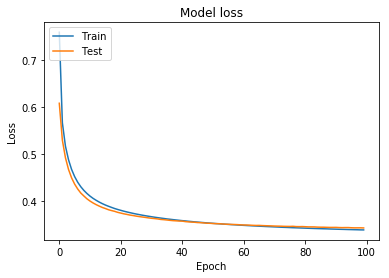

In [22]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
predictions = model.predict(new_test)
predicted_classes = np.argmax(predictions,axis=1)
true_classes = np.argmax(Y_testHot,axis=1)

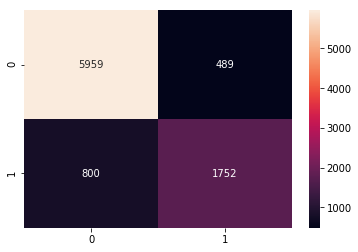

In [39]:
cm = confusion_matrix(true_classes,predicted_classes)
sns.heatmap(cm,annot=True,fmt='g')

***